# Research on credit rating of China A-share listed companies based on factor analysis and cluster analysis
Junhao Chen

cjhhao@umich.edu

## 1 Data Processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read the stocks information obtained from Wind
stocks_info = pd.read_csv('stocks_info_2014.csv')

# Excluding financial sector stocks
stocks_nofin = stocks_info[stocks_info['sector_code_name'] != '金融']
code_nofin = stocks_nofin['order_book_id'].values

# Use the random number table method to sample company samples at a ratio of 70% to obtain the training data set
stocks_nofin_train = stocks_nofin.groupby('industry_code', group_keys=False).apply(lambda x: x.sample(frac=0.6, random_state=1))
stocks_nofin_train = stocks_nofin_train['order_book_id'].values.tolist()
stocks_nofin_test = list(filter(lambda x: x not in stocks_nofin_train, code_nofin))

In [3]:
# Read the financial data set obtained from Wind
df = pd.read_csv('financial_data_2014-2024.csv')
df = df.sort_values(['order_book_id', 'date'], ascending=True).drop(columns=['cash_flow_ratio_ttm'])

# 14 financial factors
factors_list = df.columns.tolist()[2:]

df = pd.merge(df, stocks_info[['order_book_id','industry_code']], on='order_book_id', how='left')
df['year'] = df['date'].apply(lambda x: x[:4])

# Process the missing date
df_dropna = df.copy()
for f in factors_list:
    df_dropna[f] = df_dropna.groupby(['order_book_id','year'])[f].ffill()
df_dropna = df_dropna.dropna(axis=0, how='any')
df_dropna.head()

,order_book_id,date,diluted_earnings_per_share_ttm,return_on_asset_net_profit_ttm,return_on_equity_ttm,net_profit_to_revenue_ttm,account_payable_turnover_rate_ttm,inventory_turnover_ttm,current_asset_turnover_ttm,current_ratio_ttm,debt_to_asset_ratio_ttm,time_interest_earned_ratio_ttm,long_term_debt_to_working_capital_ttm,total_asset_growth_ratio_ttm,operating_revenue_growth_ratio_ttm,ocf_to_debt_ttm,industry_code,year
0,000002.XSHE,2014-01-02,1.237555,0.04022,0.211062,0.141139,1.73384,0.266353,0.297534,1.345163,0.793384,25.903725,0.331155,0.315417,0.358914,-0.014451,K70,2014
1,000002.XSHE,2014-01-03,1.237555,0.04022,0.211062,0.141139,1.73384,0.266353,0.297534,1.345163,0.793384,25.903725,0.331155,0.315417,0.358914,-0.014451,K70,2014
2,000002.XSHE,2014-01-06,1.237555,0.04022,0.211062,0.141139,1.73384,0.266353,0.297534,1.345163,0.793384,25.903725,0.331155,0.315417,0.358914,-0.014451,K70,2014
3,000002.XSHE,2014-01-07,1.237555,0.04022,0.211062,0.141139,1.73384,0.266353,0.297534,1.345163,0.793384,25.903725,0.331155,0.315417,0.358914,-0.014451,K70,2014
4,000002.XSHE,2014-01-08,1.237555,0.04022,0.211062,0.141139,1.73384,0.266353,0.297534,1.345163,0.793384,25.903725,0.331155,0.315417,0.358914,-0.014451,K70,2014


In [4]:
# Set the data time used to build the model & the data time used to test the model's predictive power
df_build = df_dropna[(df_dropna['date'] < '2024-01-01') & (df_dropna['date'] >= '2014-01-01')] # 2014-2023
df_pred = df_dropna[df_dropna['date'] >= '2024-01-01'] # 2024

# Excluding financial industry stocks
factor_train = df_build[df_build['order_book_id'].isin(stocks_nofin_train)]
factor_test = df_build[df_build['order_book_id'].isin(stocks_nofin_test)]

In [5]:
# De-extreme function
def winsorize_matrix(matrix, lower_quantile=0.05, upper_quantile=0.95):
    lower = np.percentile(matrix, lower_quantile * 100, axis=0)
    upper = np.percentile(matrix, upper_quantile * 100, axis=0)
    return np.clip(matrix, lower, upper)

# Normalized function
def standardize_matrix(matrix):
    mean = matrix.mean(axis=0)
    std = matrix.std(axis=0)
    return (matrix - mean) / std

def data_processing(df):
    results = []

    for year, group in df.groupby('date'):
        industries = pd.get_dummies(group['industry_code'], drop_first=True).values  # Industry dummy variable
        factors = group[factors_list].values

        # De-extreme
        factors_winsorized = winsorize_matrix(factors)

        # Industry neutrality (regression method)
        beta = np.linalg.lstsq(industries, factors_winsorized, rcond=None)[0]
        fitted_values = industries @ beta
        factors_neutralized = factors_winsorized - fitted_values

        # Normalized
        factors_standardized = standardize_matrix(factors_neutralized)

        result = pd.DataFrame(
            factors_standardized,
            columns=[factors_list]
        )
        result['Date'] = group['date'].values
        result['year'] = year
        result['order_book_id'] = group['order_book_id'].values
        results.append(result)

    final_results = pd.concat(results, ignore_index=True)
    final_results.columns = final_results.columns.get_level_values(0)
    final_results = final_results.groupby('order_book_id')[factors_list].mean()

    return final_results

## 2 Factory Analysis

### 2.1 Choose the appropriate number of factors

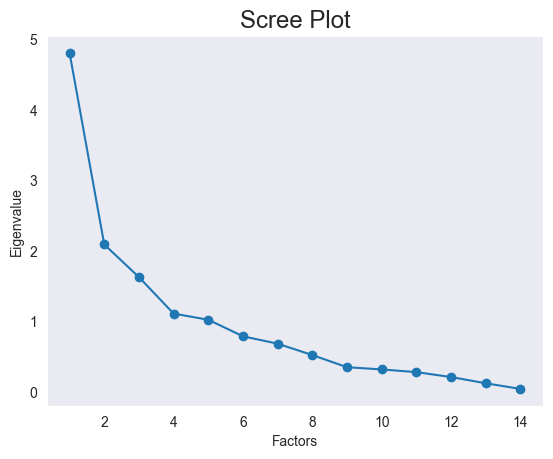

In [6]:
factor_table_train = data_processing(factor_train)

from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer(n_factors=len(factors_list), rotation = None)
fa.fit(factor_table_train)

# eigenvalues and eigenvectors
ev, v = fa.get_eigenvalues()

# Visualize the eigenvalue sequence and draw a scree plot
plt.scatter(range(1, factor_table_train.shape[1]+1), ev)
plt.plot(range(1, factor_table_train.shape[1]+1), ev)
plt.title('Scree Plot',fontsize='xx-large')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

### 2.2 Output factor loading matrix

Text(0.5, 1.0, 'Factor Analysis--Headmap')

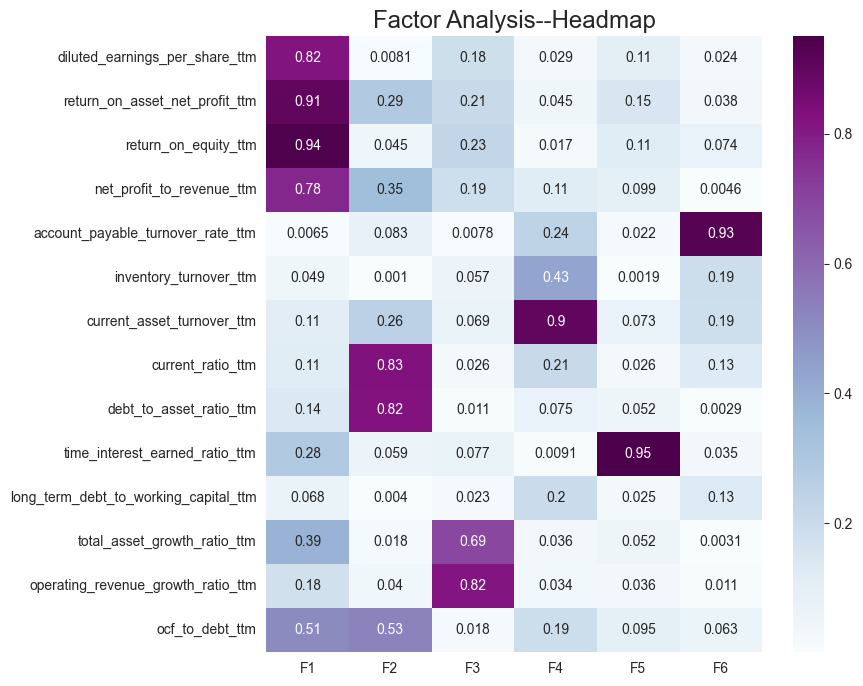

In [7]:
# Output factor loading matrix
num_factor = 6
factor_symbol_list = ['F' + str(i) for i in range(1, num_factor+1)]

fa = FactorAnalyzer(n_factors = num_factor, rotation = 'varimax')
fa.fit(factor_table_train)


Loading = pd.DataFrame(fa.loadings_, index = factor_table_train.columns)
Loading.columns = factor_symbol_list

# Visualize the factor loading matrix
import seaborn as sns
Loading_cm = pd.DataFrame(np.abs(fa.loadings_),
                          index = factor_table_train.columns,
                          columns = factor_symbol_list)
plt.figure(figsize = (8,8))
ax = sns.heatmap(Loading_cm, annot = True, cmap = "BuPu")
plt.title('Factor Analysis--Headmap',fontsize = 'xx-large')

### 2.3 Calculate factor score

In [8]:
# Generate factor score coefficient matrix (inverse of coefficient matrix multiplied by factor loading matrix)
import numpy.linalg as nlg
X1 = np.asmatrix(factor_table_train.corr())
X1 = nlg.inv(X1)

factor_score = np.dot(X1,fa.loadings_)
factor_score = pd.DataFrame(factor_score)
factor_score.columns = factor_symbol_list
factor_score.index = factor_table_train.corr().columns
factor_score

,F1,F2,F3,F4,F5,F6
diluted_earnings_per_share_ttm,0.075513,-0.068859,-0.022556,-0.031064,-0.016007,0.013928
return_on_asset_net_profit_ttm,0.530608,0.424350,-0.090233,0.164301,-0.144246,-0.172825
return_on_equity_ttm,0.569168,-0.571973,-0.100075,-0.359219,-0.152793,0.259455
net_profit_to_revenue_ttm,-0.004432,0.105017,0.018785,0.082500,-0.005639,-0.060392
account_payable_turnover_rate_ttm,-0.039363,-0.010090,-0.017726,-0.156293,-0.022923,1.007434
inventory_turnover_ttm,0.012423,0.022589,-0.022429,0.038820,-0.002926,-0.001547
current_asset_turnover_ttm,-0.066777,0.048433,0.093930,1.046925,0.008418,-0.224608
current_ratio_ttm,-0.100224,0.456167,0.048035,0.091512,-0.002468,-0.020071
debt_to_asset_ratio_ttm,0.083093,-0.353843,-0.020750,-0.064974,0.001222,0.025265
time_interest_earned_ratio_ttm,-0.135368,-0.023161,-0.016562,-0.071957,1.088689,0.000251


In [9]:
# The company's 5 factor scores
factor_5_score = pd.DataFrame(fa.transform(factor_table_train),
                            index = factor_table_train.index,
                            columns = factor_symbol_list)
factor_5_score

,F1,F2,F3,F4,F5,F6
order_book_id,,,,,,
000005.XSHE,0.278087,-0.225740,0.130089,-0.792935,-0.017200,-0.921416
000007.XSHE,-0.856538,0.858789,-0.231427,0.309129,1.770247,0.038217
000009.XSHE,1.108021,-1.111861,0.682433,-0.900069,-0.265630,0.410029
000011.XSHE,1.939664,-0.069919,-0.477731,-0.036411,-2.294885,-0.072179
000014.XSHE,-0.180754,0.364521,-0.028354,-0.110238,1.950964,-0.442169
...,...,...,...,...,...,...
603328.XSHG,1.501812,1.914387,-1.565241,0.234920,-0.499049,-0.483551
603333.XSHG,-1.428160,0.820663,-0.816408,-0.469840,-0.183650,1.352456
603456.XSHG,0.001325,0.011440,1.595502,0.295531,1.009418,-0.505070


In [10]:
# The company's comprehensive score is calculated based on the variance contribution rate of each factor.
factor_var = fa.get_factor_variance()[1]
print('Variance contribution rate of 5 factors： \n',factor_var)

factor_score_overall = pd.DataFrame(index = factor_table_train.index)
factor_score_overall['score'] = np.dot(factor_5_score,factor_var)
factor_score_overall = factor_score_overall.sort_values('score',ascending = False)
factor_score_overall

Variance contribution rate of 5 factors： 
 [0.25314845 0.13743136 0.09471248 0.08592376 0.07010174 0.0695711 ]


,score
order_book_id,
002711.XSHE,1.037183
002041.XSHE,1.032669
002690.XSHE,1.003293
600987.XSHG,0.987109
600763.XSHG,0.972211
...,...
600227.XSHG,-0.859097
000506.XSHE,-0.901481
300169.XSHE,-0.904994


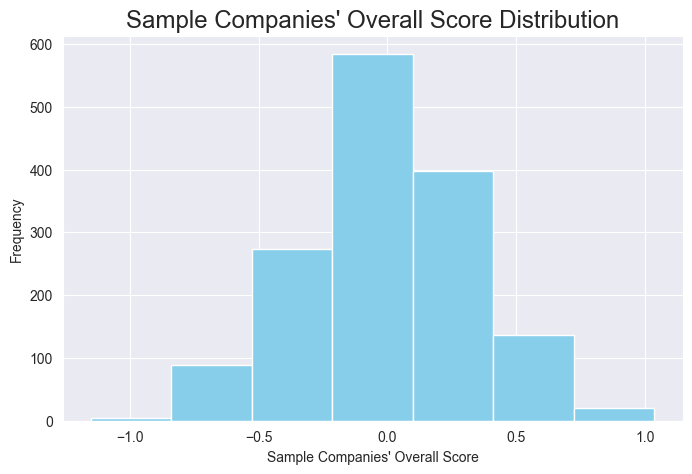

In [11]:
# Visualize the comprehensive score frequency distribution histogram
plt.figure(figsize = (8,5))
plt.hist(factor_score_overall['score'], bins = 7, color = 'skyblue', edgecolor = 'white')
plt.title('Sample Companies\' Overall Score Distribution',fontsize='xx-large')
plt.xlabel('Sample Companies\' Overall Score')
plt.ylabel('Frequency')
plt.show()

## 3 Clustering analysis


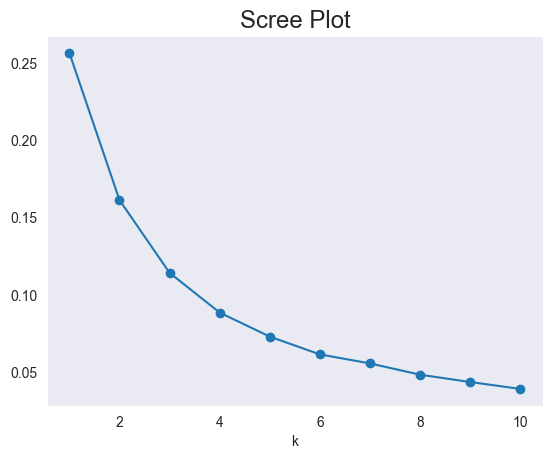

In [12]:
# KMeans
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

K = range(1, 11)

meandistortions = []
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(factor_score_overall)
    meandistortions.append(
        sum(
            np.min(cdist(factor_score_overall,kmeans.cluster_centers_,'euclidean'),axis = 1)
        ) / factor_score_overall.shape[0])

plt.scatter(K,meandistortions)
plt.plot(K,meandistortions)
plt.title('Scree Plot',fontsize = 'xx-large')
plt.xlabel('k')
plt.grid()
plt.show()

In [13]:
np.random.seed(169)

num_clusters = 7  # The number of categories is set to 7
km = KMeans(n_clusters = num_clusters).fit(factor_score_overall)

label = pd.Series(km.labels_)
num = pd.Series(km.labels_).value_counts()
center = pd.DataFrame(km.cluster_centers_)

cluster_result = pd.concat([center,num], axis=1)
cluster_result.columns = ['Final cluster center','Number of companies in each category']

cluster_result = cluster_result.sort_values('Final cluster center',ascending = False).reset_index(drop = True).T
cluster_result.columns = ['Level 1','Level 2','Level 3','Level 4','Level 5','Level 6','Level 7']
cluster_result.iloc[1] = cluster_result.iloc[1].apply(lambda x: str(int(x)))
cluster_result

,Level 1,Level 2,Level 3,Level 4,Level 5,Level 6,Level 7
Final cluster center,0.727591,0.449178,0.239801,0.057725,-0.117821,-0.32712,-0.604884
Number of companies in each category,51,171,251,338,337,232,125


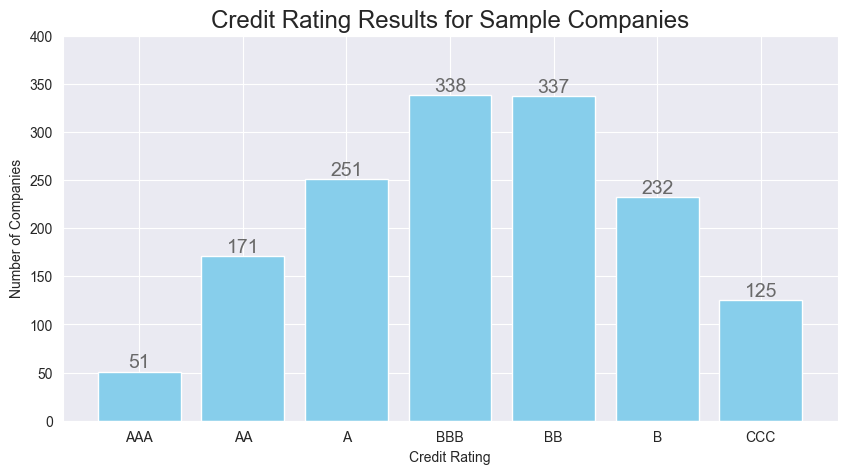

In [14]:
# Visualize classification results
index = ['AAA','AA','A','BBB','BB','B','CCC']
num = cluster_result.iloc[1].apply(lambda x: int(x))
plt.figure(figsize = (10,5))
plt.bar(index, num, color = 'skyblue')
for i in range(len(num)):
    plt.text(index[i], num[i], num[i], fontsize = 14, color = 'dimgray', ha='center',va='bottom')
plt.title('Credit Rating Results for Sample Companies',fontsize = 'xx-large')
plt.ylim(0, 400)
plt.xlabel('Credit Rating')
plt.ylabel('Number of Companies')
plt.show()

## 4 Construction of credit rating model

In [15]:
# Calculate the dividing line for each credit rating
center_sort = center.sort_values(0)[0].tolist()

Rating_indicators = []
for i in range(len(center_sort)-1):
    Rating_indicators.append((center_sort[i]+center_sort[i+1])/2)

# Generate credit rating function
def Credit_Rating(X):
    if X <= Rating_indicators[0]:
        rank = 'CCC'
    elif X > Rating_indicators[0] and X <= Rating_indicators[1]:
        rank = 'B'
    elif X > Rating_indicators[1] and X <= Rating_indicators[2]:
        rank = 'BB'
    elif X > Rating_indicators[2] and X <= Rating_indicators[3]:
        rank = 'BBB'
    elif X > Rating_indicators[3] and X <= Rating_indicators[4]:
        rank = 'A'
    elif X > Rating_indicators[4] and X <= Rating_indicators[5]:
        rank = 'AA'
    else:
        rank = 'AAA'
    return rank

According to the principle of the shortest distance between the comprehensive score of the listed company and the central point, the following seven-level credit standard rating table is obtained:

| Level | Score                      |
|:-----:|:---------------------------|
|  AAA  | score > 0.5884             |
|  AA   | 0.3445 < score <= 0.5884   |
|   A   | 0.1488 < score <= 0.3445   |
|  BBB  | -0.0300 < score <= 0.1488  |
|  BB   | -0.2225 < score <= -0.0300 |
|   B   | -0.4660 < score <= -0.2225 |
|  CCC  | score <= -0.4660           |

## 5 Test of Credit Rating Models

### 5.1 Test all listed companies outside the modeling sample

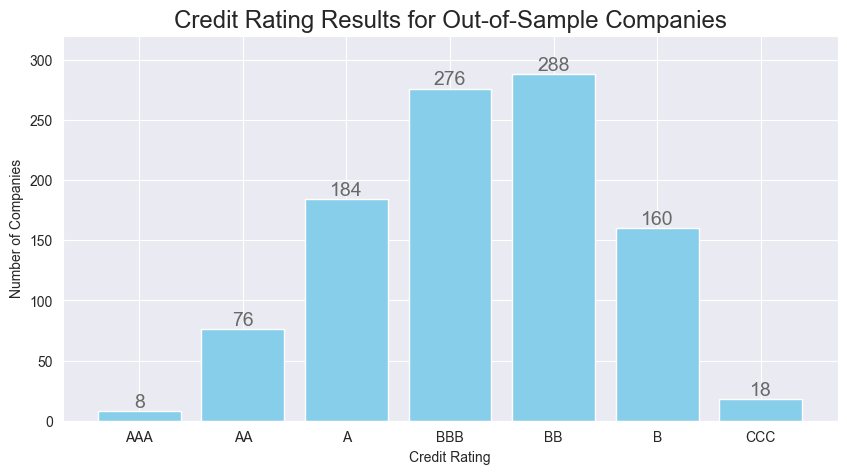

In [16]:
factor_table_test = data_processing(factor_test)

# Calculate the single factor score for each sample
single_score_test = np.dot(np.asmatrix(factor_table_test), np.asmatrix(factor_score))
single_score_test = pd.DataFrame(single_score_test)

# Calculate the comprehensive score of each sample
score_overall_test = pd.DataFrame(index = factor_table_test.index)
score_overall_test['score'] = np.dot(single_score_test,factor_var)
score_overall_test = score_overall_test.sort_values('score',ascending = False)

# Rating
rank_test = score_overall_test.copy()
rank = [Credit_Rating(score) for score in rank_test['score'].tolist()]
rank_test['rank'] = rank

# Calculate the number of companies at each class
rank_num_test = pd.DataFrame(index = ['AAA','AA','A','BBB','BB','B','CCC'])
rank_num_test['num'] = rank_test['rank'].value_counts()
rank_num_test = rank_num_test.fillna(0)

plt.figure(figsize = (10,5))
index = ['AAA','AA','A','BBB','BB','B','CCC']
num = [int(num) for num in rank_num_test['num'].tolist()]
plt.bar(index, num, color = 'skyblue')
for i in range(len(num)):
    plt.text(index[i], num[i], num[i],fontsize = 14, color = 'dimgray', ha='center',va='bottom')
plt.title('Credit Rating Results for Out-of-Sample Companies',fontsize = 'xx-large')
plt.ylim(0, 320)
plt.xlabel('Credit Rating')
plt.ylabel('Number of Companies')
plt.show()

### 5.2 Test the ST listed companies in the modeling sample

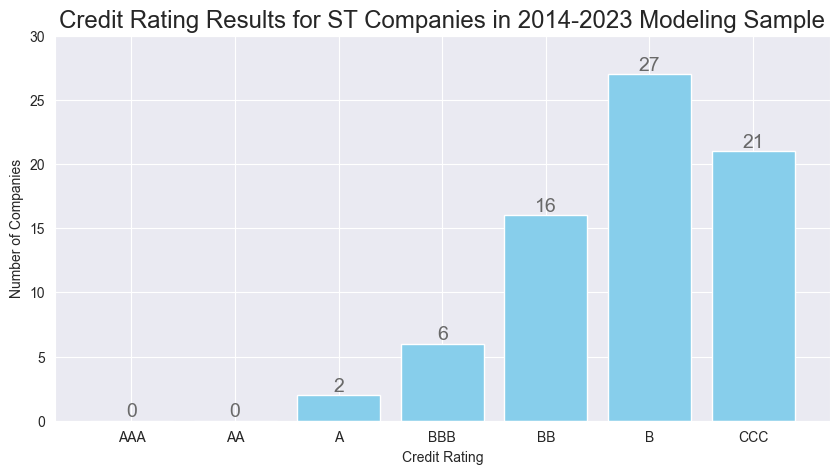

In [17]:
# Read the ST company information from Wind
company_ST = pd.read_csv('is_st_stock_2014-2024.csv')
company_ST_model = company_ST[company_ST.iloc[:,0].apply(lambda x: int(x[:4]) <= 2023)]
company_ST_model = company_ST_model.set_index(company_ST_model.columns[0])

# Select the stock codes of companies that have been marked as ST for at least 2 year
stocks_ST_list1 = company_ST_model.columns[company_ST_model.sum() > 730].tolist()

# Based on the company comprehensive scoring model, calculate the comprehensive scores of the companies
# in the sample that have been marked as ST for more than 2 years from 2014 to 2023
factor_score_overall_test = factor_score_overall.copy()
company_ST_score_overall_test1 = factor_score_overall_test[factor_score_overall_test.index.isin(stocks_ST_list1)]
company_ST_score_overall_test1.columns = ['score_ST']

company_ST_rank1 = company_ST_score_overall_test1.copy()
rank1 = [Credit_Rating(score) for score in company_ST_rank1['score_ST'].tolist()]
company_ST_rank1['rank'] = rank1

# Calculate the number of ST companies at each class
rank_num1 = pd.DataFrame(index = ['AAA','AA','A','BBB','BB','B','CCC'])
rank_num1['num'] = company_ST_rank1['rank'].value_counts()
rank_num1 = rank_num1.fillna(0)

plt.figure(figsize = (10,5))
index = ['AAA','AA','A','BBB','BB','B','CCC']
num = [int(num) for num in rank_num1['num'].tolist()]
plt.bar(index, num, color = 'skyblue')
for i in range(len(num)):
    plt.text(index[i], num[i], num[i],fontsize = 14, color = 'dimgray', ha='center',va='bottom')
plt.title('Credit Rating Results for ST Companies in 2014-2023 Modeling Sample',fontsize = 'xx-large')
plt.ylim(0, 30)
plt.xlabel('Credit Rating')
plt.ylabel('Number of Companies')
plt.show()

Text(50.722222222222214, 0.5, 'True')

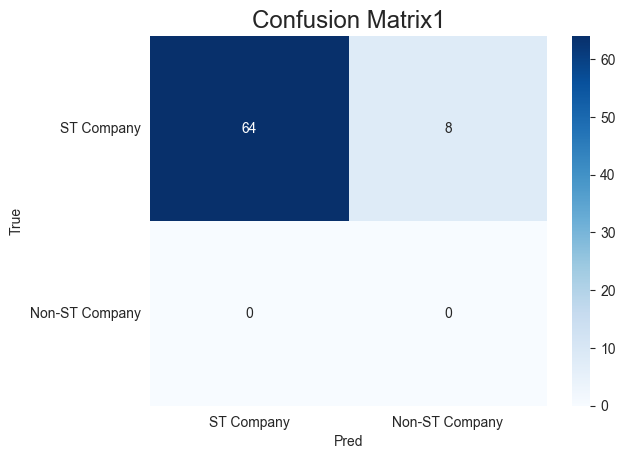

In [18]:
# Companies with ratings in the last 3 classes are rated as predicted ST companies and marked as 0;
# non-ST companies are marked 1
result1 = pd.DataFrame(columns = ['True','Pred'], index = company_ST_rank1.index)
result1['True'] = 0
for i in range(len(result1)):
    if company_ST_rank1.iloc[i,1] in ['AAA','AA','A','BBB']:
        result1.iloc[i,1] = 1
    else:
        result1.iloc[i,1] = 0

# Generate confusion matrix
from sklearn.metrics import confusion_matrix

y_true1 = result1['True'].tolist()
y_pred1 = result1['Pred'].tolist()
cm1 = confusion_matrix(y_true1, y_pred1)

Loading_cm = pd.DataFrame(cm1, columns = ['ST Company','Non-ST Company'])
ax = sns.heatmap(Loading_cm, annot = True, cmap = "Blues")
ax.set_yticklabels(['ST Company','Non-ST Company'],rotation=0)
plt.title('Confusion Matrix1',fontsize = 'xx-large')
plt.xlabel('Pred')
plt.ylabel('True')

### 5.3 Test the model’s predictive power

In this section, we selected companies that were marked as ST during 2024 as samples, and used the financial data of these companies from 2014 to 2023 to perform credit ratings on them to examine the predictive ability of the model.

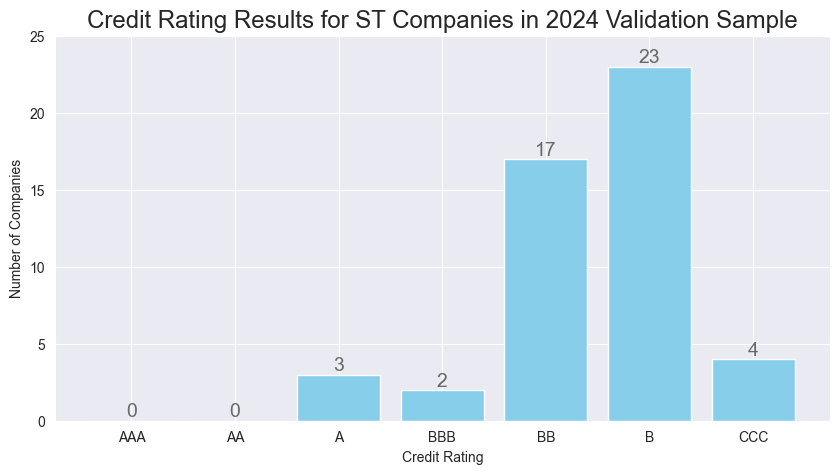

In [19]:
company_ST_model_pred = company_ST[company_ST.iloc[:,0].apply(lambda x: int(x[:4]) == 2024)]
company_ST_model_pred = company_ST_model_pred.set_index(company_ST_model_pred.columns[0])
stocks_ST_list2 = company_ST_model_pred.columns[company_ST_model_pred.sum() > 90].tolist()

# Rating
company_ST_rank2 = rank_test[rank_test.index.isin(stocks_ST_list2)]

# Calculate the number of ST companies at each class
rank_num2 = pd.DataFrame(index = ['AAA','AA','A','BBB','BB','B','CCC'])
rank_num2['num'] = company_ST_rank2['rank'].value_counts()
rank_num2 = rank_num2.fillna(0)

plt.figure(figsize = (10,5))
index = ['AAA','AA','A','BBB','BB','B','CCC']
num = [int(num) for num in rank_num2['num'].tolist()]
plt.bar(index, num, color = 'skyblue')
for i in range(len(num)):
    plt.text(index[i], num[i], num[i],fontsize = 14, color = 'dimgray', ha='center',va='bottom')
plt.title('Credit Rating Results for ST Companies in 2024 Validation Sample',fontsize = 'xx-large')
plt.ylim(0, 25)
plt.xlabel('Credit Rating')
plt.ylabel('Number of Companies')
plt.show()

Text(50.722222222222214, 0.5, 'True')

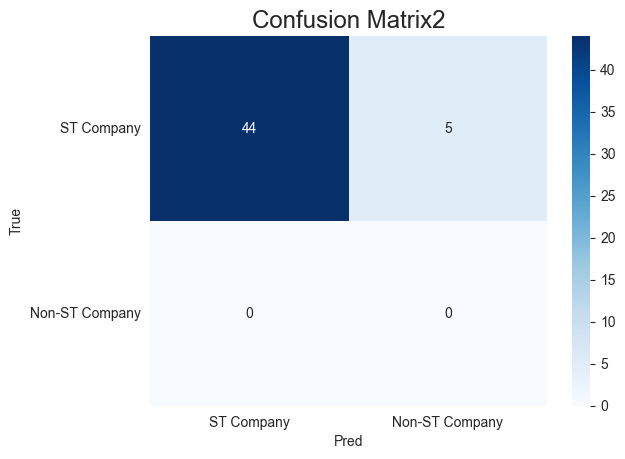

In [24]:
result2 = pd.DataFrame(columns = ['True','Pred'], index = company_ST_rank2.index)
result2['True'] = 0
for i in range(len(result2)):
    if company_ST_rank2.iloc[i,1] in ['AAA','AA','A','BBB']:
        result2.iloc[i,1] = 1
    else:
        result2.iloc[i,1] = 0

# Generate confusion matrix
y_true2 = result2['True'].tolist()
y_pred2 = result2['Pred'].tolist()
cm2 = confusion_matrix(y_true2, y_pred2)

Loading_cm = pd.DataFrame(cm2, columns = ['ST Company','Non-ST Company'])
ax = sns.heatmap(Loading_cm, annot = True, cmap = "Blues")
ax.set_yticklabels(['ST Company','Non-ST Company'],rotation=0)
plt.title('Confusion Matrix2',fontsize = 'xx-large')
plt.xlabel('Pred')
plt.ylabel('True')